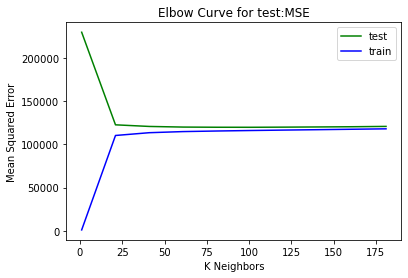

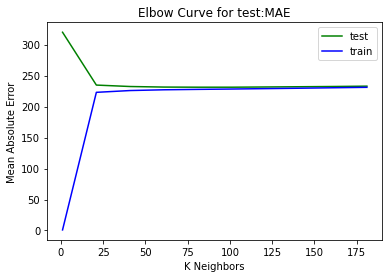

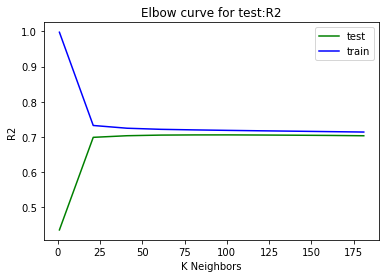

,K,test_mse,train_mse,test_r2,train_r2,test_mae,train_mae
0,1,229435.664293,1074.564589,0.436016,0.997392,320.034672,0.915835
1,21,122481.406331,110170.961424,0.698924,0.732608,234.741452,223.026161
2,41,120610.551719,113387.175237,0.703523,0.724802,232.419020,225.919071
3,61,119883.775721,114672.748872,0.705309,0.721682,231.520260,227.140654
4,81,119682.027961,115345.345928,0.705805,0.720050,231.321775,227.793810
5,101,119650.300166,115907.153211,0.705883,0.718686,231.309799,228.359853
6,121,119808.619527,116419.065448,0.705494,0.717444,231.665941,229.008817
7,141,120024.119113,116881.934231,0.704964,0.716320,232.059875,229.663456
8,161,120274.965126,117375.003084,0.704348,0.715124,232.452016,230.410618
9,181,120653.650399,117851.398054,0.703417,0.713967,232.995365,231.117266


In [23]:
# K nearest neighbour
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_squared_error as mse
import geopy.distance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

df = pd.read_csv('nyc_taxi_trip_duration Dataset.csv')
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)

df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

#short_distance
from geopy.distance import geodesic,great_circle
list1=[]
for i in range(0,df.shape[0]):
    coords_1 = (df["pickup_latitude"][i],df["pickup_longitude"][i])
    coords_2 = (df['dropoff_latitude'][i],df["dropoff_longitude"][i])
    c=great_circle(coords_1,coords_2).km
    list1.append(c)
df["Short_distance"]=list1    

#removing outliers
df=df[df["trip_duration"]<6000]
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df.drop(["id","pickup_datetime","dropoff_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","store_and_fwd_flag"],axis=1,inplace=True)

#binning of target continous variable for stratified sampling
from matplotlib import *
bins=np.linspace(min(df["log_trip_duration"]),max(df["log_trip_duration"]),201)  #for n equal bins we use n+1 dividers.therfore 4 dividers.
group_names=list(range(0,200))
df["log_binned"]=pd.cut(df["log_trip_duration"],bins,labels=group_names,include_lowest=True)   #new column=cut(column,bins,labels,include_lowest)

#Stratify sample
df=df.groupby('log_binned', group_keys=False).apply(lambda x: x.sample(frac=0.4,random_state=123))
#df=df.sample(n=85000,random_state=321)

#TRAIN and ERROR
x = df.drop(['trip_duration','log_trip_duration','log_binned'], axis=1)
y = df['trip_duration']
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2,random_state=120)

def Elbow(K):
  #initiating empty list
    test_mse = []
    train_mse=[]
    test_r2 = []
    train_r2=[]
    test_mae = []
    train_mae=[]
  
  #training model for evey value of K
    for i in K:
        #Instance of KNN
        reg = KNN(n_neighbors = i)
        reg.fit(train_x, train_y)
        
        #Appending mse value to empty list claculated using the predictions
        
        #test error mse and r2
        yhat_test = reg.predict(test_x)
        
        mse_test = mse(yhat_test,test_y)
        mae_test = mae(yhat_test,test_y)
        r2_test=r2_score(test_y,yhat_test)
        
        test_mse.append(mse_test)
        test_mae.append(mae_test)
        test_r2.append(r2_test)
        
        #train error mse and r2
        yhat_train = reg.predict(train_x)
        
        mse_train = mse(yhat_train,train_y)
        mae_train = mae(yhat_train,train_y)
        r2_train=r2_score(train_y,yhat_train)
        
        train_mse.append(mse_train)
        train_mae.append(mae_train)
        train_r2.append(r2_train)
    return test_mse,train_mse,test_r2,train_r2,test_mae,train_mae

k = range(1,200,20)
test_mse,train_mse,test_r2,train_r2,test_mae,train_mae = Elbow(k)

plt.plot(k, test_mse,color = 'green' , label = 'test')
plt.plot(k, train_mse,color = 'blue' , label = 'train')
plt.xlabel('K Neighbors')
plt.ylabel('Mean Squared Error')
plt.title('Elbow Curve for test:MSE')
#plt.ylim(0.4,1)
plt.legend()
plt.show()

plt.plot(k, test_mae,color = 'green' , label = 'test')
plt.plot(k, train_mae,color = 'blue' , label = 'train')
plt.xlabel('K Neighbors')
plt.ylabel('Mean Absolute Error')
plt.title('Elbow Curve for test:MAE')
#plt.ylim(0.4,1)
plt.legend()
plt.show()

plt.plot(k, test_r2,color = 'green' , label = 'test')
plt.plot(k, train_r2,color = 'blue' , label = 'train')
plt.xlabel('K Neighbors')
plt.ylabel('R2')
plt.title('Elbow curve for test:R2')
#plt.ylim(0.4,1)
plt.legend()
plt.show()

df_error=pd.DataFrame({"K":k,"test_mse":test_mse,"train_mse":train_mse,"test_r2":test_r2,"train_r2":train_r2,"test_mae":test_mae,"train_mae":train_mae})
df_error.head(15)